In [1]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
from scipy import signal
import scipy.io as sio

import re
import io

!pip install mne
import mne

Defaulting to user installation because normal site-packages is not writeable


In [23]:
from typing import Optional, Tuple, Dict, Any

## Import Dataset
* Ch1 - FC3  
* Ch2 - FCz
* Ch3 - FC4 
* Ch4 - C5  
* Ch5 - C3  
* Ch6 - C1     
* Ch7 - Cz 
* Ch8 - C2
* Ch9 - C4
* Ch10 - C6
* Ch11 - CP3 
* Ch12 - CP1
* Ch13 - CPz
* Ch14 - CP2
* Ch15 - CP4
* Ch16 - Pz

In [158]:
def _todict(matobj):
    """
    Convert MATLAB structs to nested Python dicts.
    Handles simple nested structs returned by scipy.io.loadmat with
    struct_as_record=False and squeeze_me=True
    """
    result = {}
    for fieldname in matobj._fieldnames:
        elem = getattr(matobj, fieldname)
        if hasattr(elem, "_fieldnames"):
            result[fieldname] = _todict(elem)
        else:
            result[fieldname] = elem
    return result


def _check_and_unpack(value):
    """
    If value is a numpy void/record or matlab object, unpack into dict/list/ndarray.
    """
    # matlab object (mat_struct) instance
    if hasattr(value, "_fieldnames"):
        return _todict(value)
    # numpy array of objects, maybe from struct array
    if isinstance(value, np.ndarray) and value.dtype == np.object_:
        try:
            # try to squeeze and take the first element if it looks like a struct wrapper
            squeezed = np.squeeze(value)
            if hasattr(squeezed, "_fieldnames"):
                return _todict(squeezed)
            return squeezed
        except Exception:
            return value
    return value


def load_mat_to_dataframe(
    path: str,
    y_name: Optional[str] = None,
    trig_name: Optional[str] = None,
    expected_n_channels: Optional[int] = None,
    channel_names: Optional[list] = None,
    return_meta: bool = False,
    verbose: bool = False,
) -> Tuple[pd.DataFrame, Optional[Dict[str, Any]]]:
    """
    Load .mat file and return a pandas DataFrame with channels and trig column.

    Parameters
    ----------
    path : str
        Path to the .mat file.
    y_name : str, optional
        Name of variable in .mat containing the signal array.
        If None, function will attempt to auto-detect the main 2D array.
    trig_name : str, optional
        Name of trigger/event vector in .mat. If None, function will try common names
        or match by length to the signal.
    expected_n_channels : int, optional
        Hint for how many channels the signal has, e.g. 16. Helps selection if multiple 2D arrays exist.
    channel_names : list, optional
        List of channel names of length n_channels. If None, channel names will be ch1, ch2, ...
    return_meta : bool, optional
        If True, return a second value with meta info (selected variable names, shapes).
    verbose : bool, optional
        Print debug info.

    Returns
    -------
    df : pandas.DataFrame
        DataFrame with shape (n_samples, n_channels + 1), last column named 'trig'
    meta : dict or None
        When return_meta True, returns { 'y_name':..., 'trig_name':..., 'shapes': {...} }
    """
    mat = sio.loadmat(path, struct_as_record=False, squeeze_me=True)

    # clean keys
    keys = [k for k in mat.keys() if not k.startswith("__")]
    if verbose:
        print("Variables found in .mat:", keys)

    # helper to collect candidate arrays
    candidates = {}
    for k in keys:
        val = mat[k]
        val = _check_and_unpack(val)
        candidates[k] = val

    # find y (2D signal)
    y = None
    chosen_y_name = None

    if y_name and y_name in candidates:
        y = candidates[y_name]
        chosen_y_name = y_name
    else:
        # try names that hint at signal
        prefer_names = ["y", "data", "signals", "eeg", "eeg_data", "X", "val"]
        for name in prefer_names:
            if name in candidates and isinstance(candidates[name], np.ndarray) and candidates[name].ndim >= 2:
                y = candidates[name]
                chosen_y_name = name
                break

    # fallback: pick the largest 2D numeric array, or the one matching expected_n_channels
    if y is None:
        two_d_arrays = {k: v for k, v in candidates.items() if isinstance(v, np.ndarray) and v.ndim == 2}
        if verbose:
            print("2D arrays found:", {k: v.shape for k, v in two_d_arrays.items()})
        if expected_n_channels is not None:
            # prefer array with one dimension equal to expected_n_channels
            for k, v in two_d_arrays.items():
                if v.shape[0] == expected_n_channels or v.shape[1] == expected_n_channels:
                    y = v
                    chosen_y_name = k
                    break
        if y is None and two_d_arrays:
            # choose largest by element count
            chosen_y_name, y = max(two_d_arrays.items(), key=lambda kv: kv[1].size)

    if y is None:
        raise ValueError("Could not find a 2D signal array in the .mat file, provide y_name or check the file.")

    # ensure numpy array
    y = np.array(y)

    # shape fix: if channels are rows and expected_n_channels matches first dim, transpose
    if y.ndim != 2:
        raise ValueError(f"Selected signal array {chosen_y_name} is not 2D, got shape {y.shape}")

    n_samples, n_channels = y.shape
    # if it's (channels, samples) swap
    if expected_n_channels is not None and n_channels != expected_n_channels and y.shape[0] == expected_n_channels:
        if verbose:
            print("Transposing y, channels are in rows, not columns.")
        y = y.T
        n_samples, n_channels = y.shape

    # second check: if channels still not as expected but first dim is much larger, assume first dim is samples
    if expected_n_channels is None and n_channels > y.shape[0]:
        # nothing to do, keep as is
        pass

    # find trig
    trig = None
    chosen_trig_name = None
    if trig_name and trig_name in candidates:
        trig = candidates[trig_name]
        chosen_trig_name = trig_name
    else:
        # try common trigger names first
        trig_candidates_names = ["trig", "trigger", "triggers", "event", "events", "markers", "marker"]
        for name in trig_candidates_names:
            if name in candidates:
                val = candidates[name]
                if isinstance(val, np.ndarray) and (val.ndim == 1 or (val.ndim == 2 and 1 in val.shape)):
                    trig = val
                    chosen_trig_name = name
                    break

    # if not found, try arrays that match length
    if trig is None:
        for k, v in candidates.items():
            if isinstance(v, np.ndarray):
                # flatten candidate shapes to length
                if v.ndim == 1 and v.shape[0] == n_samples:
                    trig = v
                    chosen_trig_name = k
                    break
                if v.ndim == 2 and (v.shape[0] == n_samples or v.shape[1] == n_samples):
                    trig = v
                    chosen_trig_name = k
                    break

    if trig is None:
        # no trig found, create a zeros vector and warn
        if verbose:
            print("No trigger vector detected, creating a zero 'trig' column.")
        trig = np.zeros(n_samples, dtype=int)
        chosen_trig_name = None

    # normalize trig shape to 1D
    trig = np.array(trig).squeeze()
    if trig.ndim != 1 or trig.shape[0] != n_samples:
        # try transpose or reshape if it's (n_samples,1) or (1,n_samples)
        if trig.ndim == 2 and (trig.shape[0] == n_samples or trig.shape[1] == n_samples):
            trig = trig.ravel()
        else:
            raise ValueError(f"Trigger vector shape {trig.shape} does not match number of samples {n_samples}")

    # build DataFrame
    if channel_names is not None:
        if len(channel_names) != n_channels:
            raise ValueError("channel_names length does not match number of channels")
        cols = channel_names
    else:
        cols = [f"ch{i+1}" for i in range(n_channels)]

    df = pd.DataFrame(y, columns=cols)
    df["trig"] = trig


    meta = {
        "y_name": chosen_y_name,
        "y_shape": y.shape,
        "trig_name": chosen_trig_name,
        "trig_shape": trig.shape,
        "n_samples": n_samples,
        "n_channels": n_channels,
    }

    if verbose:
        print("Loaded signal", meta)

    if return_meta:
        return df, meta
 
    return df, meta

In [159]:
# Get metadata too
#df, meta = load_mat_to_dataframe("your_file.mat", expected_n_channels=16, return_meta=True)
#print(meta)

# Use explicit variable names if you know them
df, meta = load_mat_to_dataframe("data\P1_pre_training.mat", y_name="y", trig_name="trig", channel_names=[f"ch{i+1}" for i in range(16)])
print(meta)


{'y_name': 'y', 'y_shape': (271816, 16), 'trig_name': 'trig', 'trig_shape': (271816,), 'n_samples': 271816, 'n_channels': 16}


In [146]:
df.head(5)

,ch1,ch2,ch3,ch4,ch5,ch6,ch7,ch8,ch9,ch10,ch11,ch12,ch13,ch14,ch15,ch16,trig
0,38001.839844,36892.000000,46397.214844,50350.613281,37726.980469,57036.867188,46999.265625,47667.355469,47781.109375,39447.503906,49432.898438,48651.296875,49362.050781,47384.273438,38979.992188,61820.179688,0
1,54828.550781,54868.156250,52444.156250,52408.507812,54521.210938,50932.191406,52738.488281,52781.171875,52272.847656,54376.527344,52604.574219,52560.785156,52507.796875,52978.863281,54474.457031,50255.472656,0
2,-24629.253906,-24865.400391,-22964.140625,-22914.605469,-24873.259766,-22113.113281,-23516.539062,-23355.142578,-22624.406250,-24587.474609,-23058.496094,-23198.757812,-23129.423828,-23339.222656,-24563.939453,-21289.884766,0
3,-77839.562500,-78191.210938,-76574.710938,-76846.210938,-78150.195312,-76362.351562,-77222.789062,-77171.906250,-76289.273438,-78103.726562,-77080.812500,-77045.546875,-76983.515625,-77237.015625,-77972.484375,-75860.140625,0
4,-48999.753906,-49155.601562,-49435.792969,-49648.988281,-49283.152344,-50093.390625,-49608.496094,-49621.535156,-49217.925781,-49437.320312,-49688.796875,-50009.597656,-49660.007812,-49592.742188,-49244.277344,-50159.144531,0


In [147]:
df.shape

(271816, 17)

In [148]:
df.columns

Index(['ch1', 'ch2', 'ch3', 'ch4', 'ch5', 'ch6', 'ch7', 'ch8', 'ch9', 'ch10',
       'ch11', 'ch12', 'ch13', 'ch14', 'ch15', 'ch16', 'trig'],
      dtype='object')

In [149]:
df.describe()

,ch1,ch2,ch3,ch4,ch5,ch6,ch7,ch8,ch9,ch10,ch11,ch12,ch13,ch14,ch15,ch16,trig
count,271816.000000,271816.000000,271816.000000,271816.000000,271816.000000,271816.000000,271816.000000,271816.000000,271816.000000,271816.000000,271816.000000,271816.000000,271816.000000,271816.000000,271816.000000,271816.000000,271816.000000
mean,-158.634849,-62.401942,-393.462122,-1867.455619,-451.789993,-510.357172,-424.919882,-445.915095,-398.677113,-434.922062,-385.399846,-2563.940475,-277.208570,-317.877191,-379.092799,-358.594691,0.000000
std,34555.736787,38064.502172,34636.156238,43374.740135,34809.260035,34773.400111,34697.779470,34865.721134,34670.438628,34757.789417,34809.551029,43789.335316,33992.150741,33911.691735,34098.532450,34048.760973,0.776378
min,-403234.187500,-383352.093750,-404016.250000,-455808.281250,-406625.593750,-405575.156250,-406884.750000,-406483.875000,-402868.875000,-403808.781250,-403821.937500,-457645.718750,-395735.656250,-395571.312500,-394307.937500,-394534.656250,-1.000000
25%,232.641670,64.461695,-37.606057,37.391302,-18.758564,-70.169296,18.684913,-22.009736,25.188777,-84.171661,-3.021342,-42.622512,60.759815,0.082577,-33.289404,-17.288617,-1.000000
50%,256.634674,88.861897,-10.964761,59.308496,1.687507,-47.533743,43.577663,0.426885,50.607193,-60.249186,15.840919,-24.089332,87.887077,33.465153,-15.595930,0.223157,0.000000
75%,370.388687,239.138687,136.366196,89.040525,108.721699,57.051946,177.577412,89.039349,145.125107,79.729914,105.662832,38.486605,227.555447,198.336864,43.761347,105.226824,1.000000
max,358119.812500,345198.812500,358821.812500,376052.437500,359421.937500,358761.125000,359550.250000,359233.468750,357844.656250,357395.718750,357450.281250,373367.250000,355197.500000,354565.718750,354573.937500,353794.156250,1.000000


In [150]:
df['trig'].nunique()

3

In [151]:
df[df['trig'] == -1]

,ch1,ch2,ch3,ch4,ch5,ch6,ch7,ch8,ch9,ch10,ch11,ch12,ch13,ch14,ch15,ch16,trig
65838,599.143921,372.026001,281.206818,145.661758,175.493774,291.693695,356.972168,230.760513,234.908661,256.582001,192.171509,132.183365,448.610291,523.696716,158.340958,197.838867,-1
65839,590.737305,361.050690,268.419586,130.823792,150.245514,268.407043,332.262146,216.259171,222.842331,244.881943,177.966324,125.428322,435.948364,501.930084,150.129852,192.365173,-1
65840,611.666809,376.292084,288.996887,151.781876,167.275955,289.666931,357.749603,237.573914,243.092819,262.182739,200.732285,146.401184,453.051086,522.689636,162.566895,192.647720,-1
65841,595.159241,361.700928,268.992371,130.855682,155.956116,275.761078,342.734894,218.474091,221.565277,246.658127,178.025574,109.876862,432.919128,486.806580,154.137604,190.529251,-1
65842,600.869507,374.406647,283.435883,150.169312,166.620850,277.407806,348.804474,234.009842,241.137817,262.942566,199.974701,141.113037,454.170380,511.270294,165.405884,190.998077,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
271795,242.781525,67.049637,-19.068010,70.790031,-19.983019,-56.141350,12.221759,-15.530634,35.991051,-80.896461,7.147117,-39.770390,64.709167,-7.892024,-22.693344,-13.952981,-1
271796,215.742676,53.115944,-36.236279,55.332569,-31.691547,-86.276329,-3.875594,-34.907341,18.115387,-94.078728,-6.348837,-48.067036,49.096142,-6.562933,-33.956944,-22.609144,-1
271797,227.186951,65.063400,-25.860865,65.729813,-30.707947,-76.613670,2.796699,-21.934059,29.927046,-83.115623,4.164769,-50.817680,62.357845,-5.930853,-26.676371,-19.922352,-1
271798,224.690292,57.086212,-30.261307,60.743656,-20.344366,-78.378143,2.439494,-28.684645,21.184464,-91.093040,-6.866218,-42.286804,53.596783,-6.648259,-28.449129,-19.770422,-1


In [152]:
df[df['trig'] == -1].value_counts().sum()

81920

In [153]:
df[df['trig'] == 1]

,ch1,ch2,ch3,ch4,ch5,ch6,ch7,ch8,ch9,ch10,ch11,ch12,ch13,ch14,ch15,ch16,trig
78019,538.407776,284.577942,217.008270,144.951645,102.956032,160.371689,266.511169,135.629776,176.695282,122.448891,121.219856,52.823376,281.868927,304.229675,63.344437,95.076012,1
78020,550.695740,295.105438,225.427490,153.456604,99.815903,172.223312,273.248962,148.608765,185.736984,130.632568,122.309441,47.292412,292.681396,307.453430,64.446022,81.637375,1
78021,563.211975,303.441254,235.341415,162.252563,95.773018,200.389191,287.629272,156.012405,195.468185,138.800293,133.540527,62.812519,301.962921,332.096161,71.698067,100.078918,1
78022,540.694275,282.758179,214.209747,141.492157,92.394684,181.384933,265.352020,133.570923,168.979721,119.109192,118.248795,63.884270,274.851990,311.895203,55.679478,103.864632,1
78023,564.948181,310.085175,243.840195,170.754883,107.687920,210.079819,292.598755,161.604614,201.584869,145.799149,142.130280,67.299446,307.015381,348.632050,74.334740,106.812218,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259019,233.126755,63.924778,-33.429794,60.262287,-31.576845,-69.694893,21.729639,-15.273890,31.474510,-88.887428,7.060484,-34.103172,60.574394,-3.637934,-16.947046,-6.880708,1
259020,235.115479,64.153412,-39.183231,59.895462,-28.405546,-69.599243,22.252895,-13.396914,30.261585,-90.566498,2.993686,-41.077267,61.183144,-5.229909,-16.334063,-5.503847,1
259021,234.167313,62.850479,-39.086857,63.098255,-34.388950,-57.915405,23.725485,-11.671236,33.615913,-90.613136,4.748469,-44.786137,61.070824,-1.697847,-22.236673,-12.567877,1
259022,223.164215,51.272194,-48.733780,51.004906,-38.531132,-68.939285,12.301775,-27.540352,17.515860,-101.280464,-4.824706,-46.925003,49.078785,-10.604307,-24.255993,-7.278707,1


In [154]:
df[df['trig'] == 1].value_counts().sum()

81920

In [155]:
right_imagery_index = list(df[df['trig'] == -1].index)
right_imagery = df[df['trig'] == -1]
print("right Imagery is",df[df['trig'] == -1].value_counts().sum(), "starting from", list(df[df['trig'] == -1].index)[0] )

right Imagery is 81920 starting from 65838


In [156]:
left_imagery_index = list(df[df['trig'] == 1].index)
left_imagery = df[df['trig'] == 1]
print("Left Imagery is",df[df['trig'] == 1].value_counts().sum(), "starting from", list(df[df['trig'] == 1].index)[0] )

Left Imagery is 81920 starting from 78019


In [157]:
zero_imagery_index = list(df[df['trig'] == 0].index)
zero_imagery = df[df['trig'] == 0]
print("Zero Imagery is",df[df['trig'] == 0].value_counts().sum(), "starting from", list(df[df['trig'] == 0].index)[0] )

Zero Imagery is 107976 starting from 0


## Convert to Microvolts

converts raw EEG data from a 24-bit ADC (ranging from 0 to 16777215) into microvolts by normalizing the data,
scaling it to a 4.5V reference voltage, and converting to microvolts,
then rounding to two decimal places. This transformation is necessary for accurately interpreting EEG signals, which are typically measured in microvolts 

In [136]:
# target names, channels 1 to 16
exg_cols = [f"ch{i}" for i in range(1, 17)]

# keep only the EXG columns that actually exist in df_imagine
exg_present = [c for c in exg_cols if c in df.columns]

if not exg_present:
    raise ValueError("No ch Channel columns found in df_imagine.")

# get integer array, handle possible NaNs safely
arr = df[exg_present].fillna(0).to_numpy(dtype=np.int64)

# convert unsigned 32 bit values to signed two's complement where needed
mask = arr >= 2**23
arr[mask] = arr[mask] - 2**24

# convert to microvolts, round to 2 decimals
df[exg_present] = np.round(1000000 * 4.5 * (arr / 16777216), 2)  # 2**32 = 16777216

display(df.head())

,ch1,ch2,ch3,ch4,ch5,ch6,ch7,ch8,ch9,ch10,ch11,ch12,ch13,ch14,ch15,ch16,trig
0,10192.66,9895.21,12444.65,13504.92,10118.90,15298.25,12606.11,12785.29,12815.86,10580.51,13258.70,13049.22,13239.92,12709.38,10454.98,16581.42,0
1,14706.02,14716.74,14066.58,14056.92,14623.67,13661.03,14145.43,14156.97,14020.44,14584.78,14109.49,14097.69,14083.47,14209.81,14611.07,13479.44,0
2,-6606.01,-6669.31,-6159.42,-6146.01,-6671.46,-5931.17,-6307.48,-6264.30,-6068.23,-6594.75,-6184.64,-6222.19,-6203.68,-6260.01,-6588.31,-5710.15,0
3,-20878.05,-20972.46,-20538.75,-20611.70,-20961.46,-20481.88,-20712.55,-20698.88,-20462.30,-20948.86,-20674.47,-20665.08,-20648.45,-20716.58,-20913.72,-20347.24,0
4,-13142.56,-13184.40,-13259.50,-13316.63,-13218.73,-13435.99,-13305.90,-13309.39,-13201.03,-13260.04,-13327.36,-13413.46,-13319.85,-13301.61,-13208.27,-13453.69,0


## Visualisation

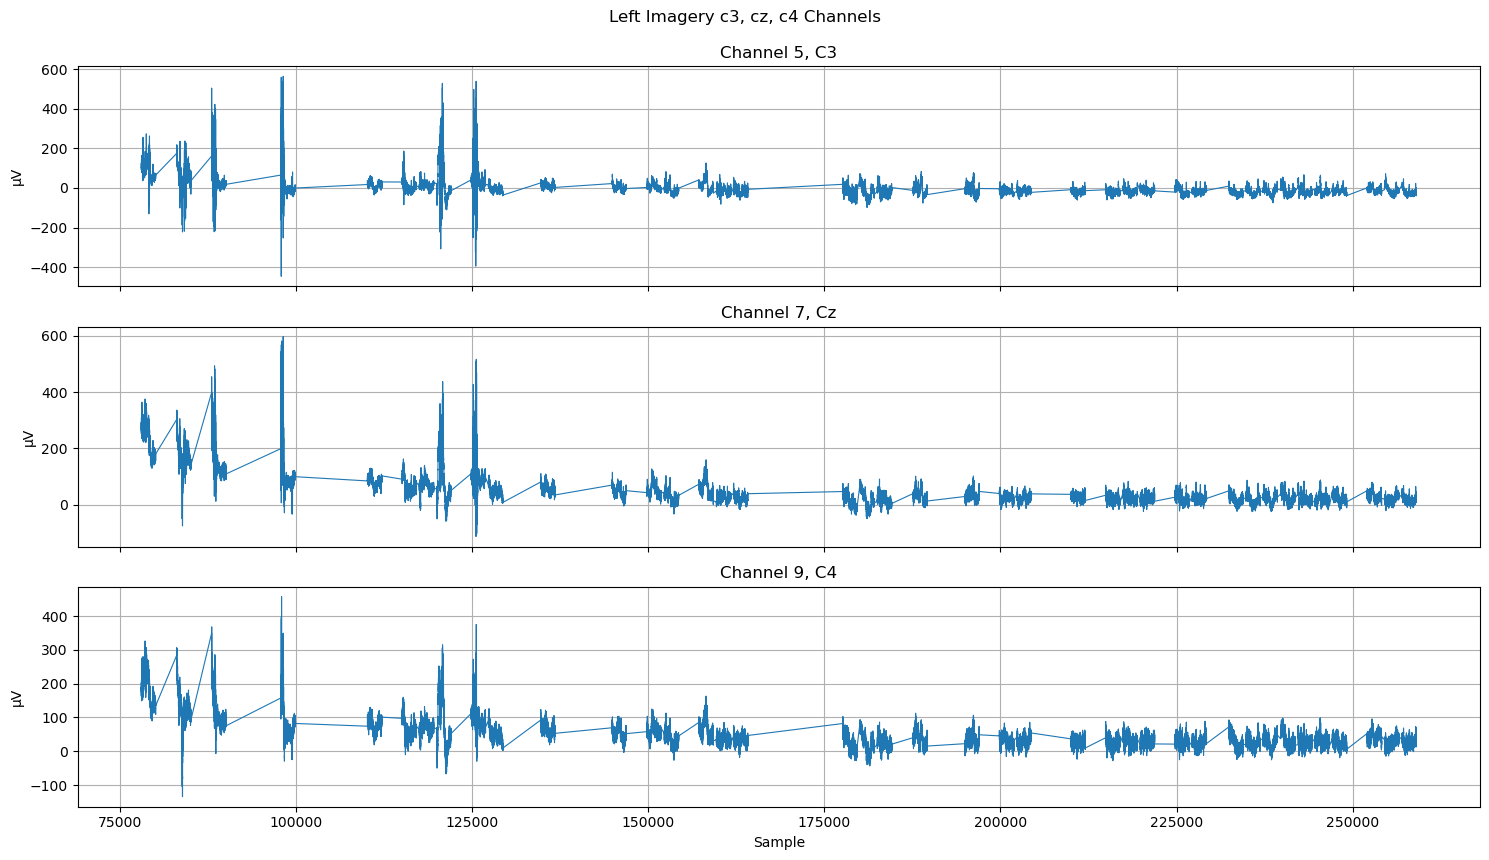

In [ ]:
## Left imagery visual
nrows, ncols = 3, 1
fig, axes = plt.subplots(nrows, ncols, figsize=(15,9), sharex=True)
axes = axes.flatten()

axes[0].plot(left_imagery['ch5'], linewidth=0.8)
axes[0].set_title("Channel 5, C3")
axes[0].grid(True)
axes[0].set_ylabel("µV")

axes[1].plot(left_imagery['ch7'], linewidth=0.8)
axes[1].set_title("Channel 7, Cz")
axes[1].grid(True)
axes[1].set_ylabel("µV")

axes[2].plot(left_imagery['ch9'], linewidth=0.8)
axes[2].set_title("Channel 9, C4")
axes[2].grid(True)
axes[2].set_ylabel("µV")


fig.suptitle("Left Imagery c3, cz, c4 Channels", y=0.95)
plt.xlabel("Sample")
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

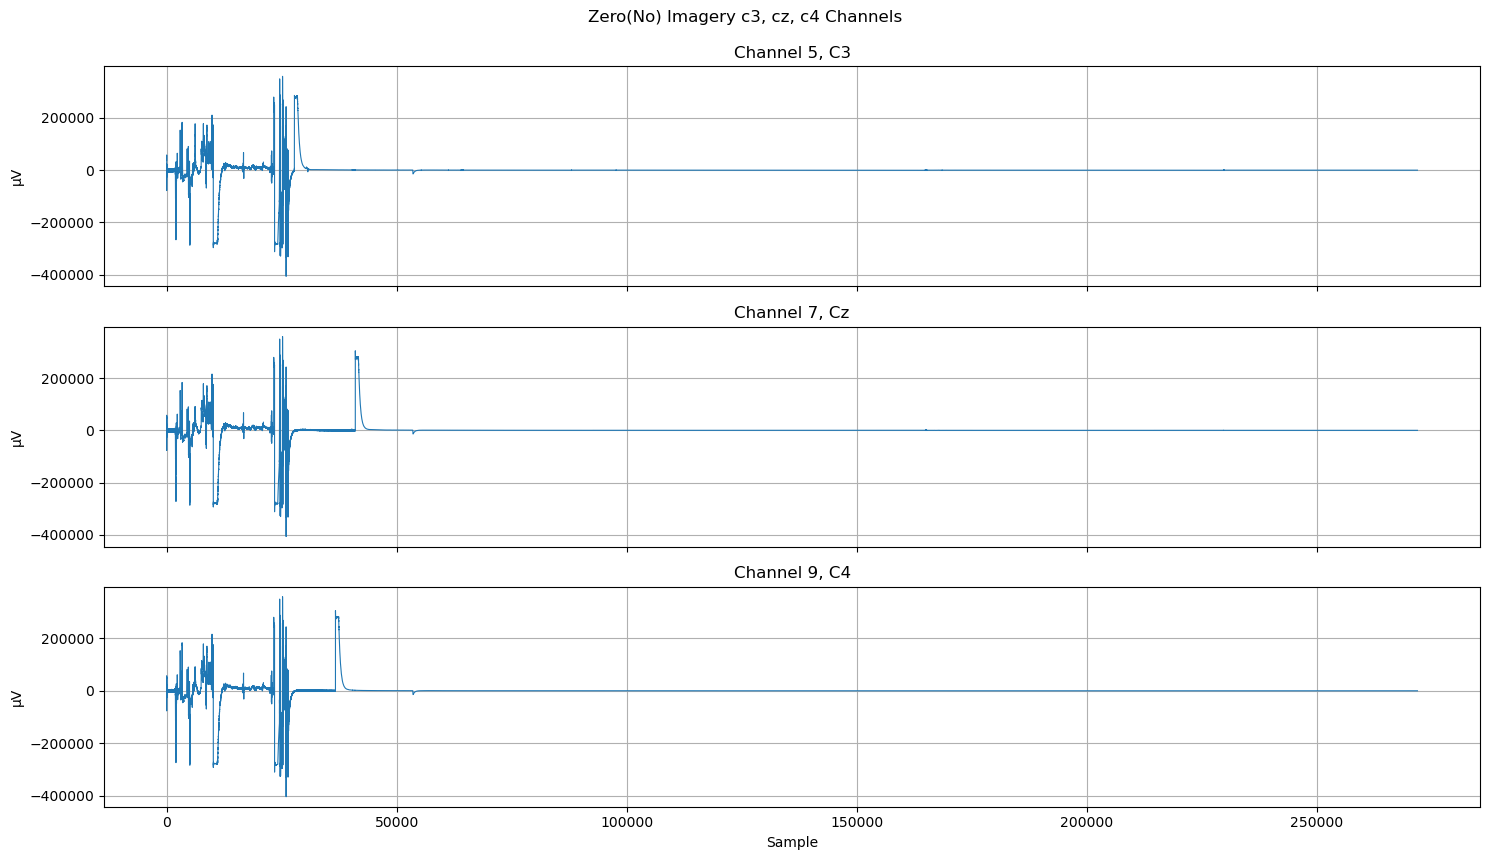

In [ ]:
## Zero or NO imagery visual
nrows, ncols = 3, 1
fig, axes = plt.subplots(nrows, ncols, figsize=(15,9), sharex=True)
axes = axes.flatten()

axes[0].plot(zero_imagery['ch5'], linewidth=0.8)
axes[0].set_title("Channel 5, C3")
axes[0].grid(True)
axes[0].set_ylabel("µV")

axes[1].plot(zero_imagery['ch7'], linewidth=0.8)
axes[1].set_title("Channel 7, Cz")
axes[1].grid(True)
axes[1].set_ylabel("µV")

axes[2].plot(zero_imagery['ch9'], linewidth=0.8)
axes[2].set_title("Channel 9, C4")
axes[2].grid(True)
axes[2].set_ylabel("µV")


fig.suptitle("Zero(No) Imagery c3, cz, c4 Channels", y=0.95)
plt.xlabel("Sample")
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

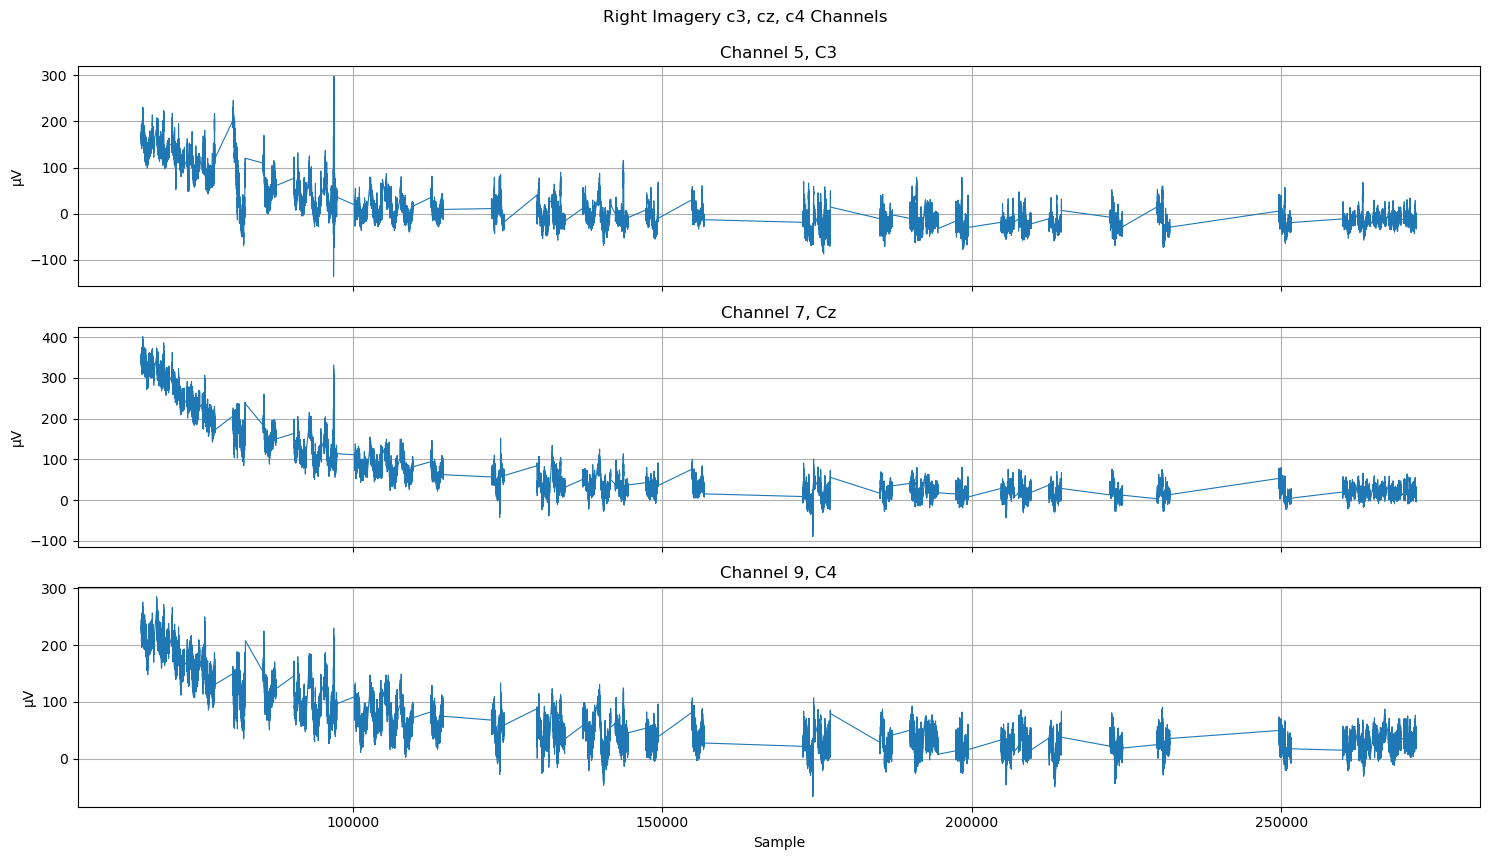

In [ ]:
## Right imagery visual
nrows, ncols = 3, 1
fig, axes = plt.subplots(nrows, ncols, figsize=(15,9), sharex=True)
axes = axes.flatten()

axes[0].plot(right_imagery['ch5'], linewidth=0.8)
axes[0].set_title("Channel 5, C3")
axes[0].grid(True)
axes[0].set_ylabel("µV")

axes[1].plot(right_imagery['ch7'], linewidth=0.8)
axes[1].set_title("Channel 7, Cz")
axes[1].grid(True)
axes[1].set_ylabel("µV")

axes[2].plot(right_imagery['ch9'], linewidth=0.8)
axes[2].set_title("Channel 9, C4")
axes[2].grid(True)
axes[2].set_ylabel("µV")


fig.suptitle("Right Imagery c3, cz, c4 Channels", y=0.95)
plt.xlabel("Sample")
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

## Drop all channles except C3, C4, Cz before it is the motor cortex area we will be focusing in this context

In [179]:
columns_to_drop = ['ch1', 'ch2','ch3','ch4','ch6','ch8','ch10','ch11','ch12','ch13','ch14','ch15','ch16']
left_imagery =  left_imagery.drop(columns_to_drop, axis=1)
left_imagery.head(2)

,ch5,ch7,ch9,trig
78019,102.956032,266.511169,176.695282,1
78020,99.815903,273.248962,185.736984,1


In [180]:
columns_to_drop = ['ch1', 'ch2','ch3','ch4','ch6','ch8','ch10','ch11','ch12','ch13','ch14','ch15','ch16']
right_imagery =  right_imagery.drop(columns_to_drop, axis=1)
right_imagery.head(2)

,ch5,ch7,ch9,trig
65838,175.493774,356.972168,234.908661,-1
65839,150.245514,332.262146,222.842331,-1


In [ ]:
columns_to_drop = ['ch1', 'ch2','ch3','ch4','ch6','ch8','ch10','ch11','ch12','ch13','ch14','ch15','ch16']
zero_imagery =  zero_imagery.drop(columns_to_drop, axis=1)
zero_imagery.head(2)

,ch5,ch7,ch9,trig
0,37726.980469,46999.265625,47781.109375,0
1,54521.210938,52738.488281,52272.847656,0


## Pre Processing

##
* Ch5 - C3  
* Ch7 - C4  
* Ch9 - Cz  

# Temporal Filter

Band-pass filtering is a common signal processing technique used in EEG (Electroencephalography) data analysis to isolate specific frequency bands of interest while removing unwanted frequencies. Band-pass filtering allows researchers to focus on particular brainwave rhythms that are relevant to their study. For example, you might want to extract the alpha, beta, or gamma waves from the EEG data.

Band-pass Filtering Functions

The script defines Butterworth low-pass and high-pass filters using SciPy:

- butter_lowpass and butter_highpass create filter coefficients based on cutoff frequencies and sampling rate (fs).

- butter_lowpass_filter and butter_highpass_filter apply these filters to the EEG signal data.

- High-pass filters remove low-frequency noise below the cutoff.

- Low-pass filters remove high-frequency noise above the cutoff.

Combining high-pass followed by low-pass creates a band-pass filter, isolating the EEG signal frequencies of interest.
A bandpass filter + notch filter
8 - 30 Hz

In [ ]:
def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = signal.butter(order, normal_cutoff, btype='low', analog=False)
    return b, a
def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = signal.lfilter(b, a, data)
    return y

def butter_highpass(cutoff, fs, order=3):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = signal.butter(order, normal_cutoff, btype='high', analog=False)
    return b, a
def butter_highpass_filter(data, cutoff, fs, order=5):
    b, a = butter_highpass(cutoff, fs, order=order)
    y = signal.filtfilt(b, a, data)
    return y